# **FC-DNN**

In [1]:
import numpy as np
import mne
import pandas as pd
import mne_bids
import matplotlib.pyplot as plt
import soundfile as sf
import os
import pickle
from datetime import datetime, timedelta
from pydub import AudioSegment
from Extra import WaveGlow_functions
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
import tensorflow as tf
import scipy.signal
import scipy.io as sio
import librosa

/usr/local/lib/python3.8/dist-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
2023-12-06 08:30:26.174743: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 08:30:28.216262: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-12-06 08:30:28.217107: W tensorflow/compile

In [2]:
# do not use all GPU memory
import tensorflow.compat.v1 as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

2023-12-06 08:30:29.717858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 08:30:29.946356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 08:30:30.085520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 08:30:30.085864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_nod

### **Helper functions**

In [3]:
#Small helper function to speed up the hilbert transform by extending the length of data to the next power of 2
hilbert3 = lambda x: scipy.signal.hilbert(
    x, scipy.fftpack.next_fast_len(len(x)), axis=0)[:len(x)]

In [4]:
def extractHG(data,
              sr,
              windowLength=0.05,
              frameshift=0.01,
              bandpass_min=1,
              bandpass_max=70):
    """
    Window data and extract frequency-band envelope using the hilbert transform
    
    Parameters
    ----------
    data: array (samples, channels)
        EEG time series
    sr: int
        Sampling rate of the data
    windowLength: float
        Length of window (in seconds) in which spectrogram will be calculated
    frameshift: float
        Shift (in seconds) after which next window will be extracted
    Returns
    ----------
    feat: array (windows, channels)
        Frequency-band feature matrix
    """
    #Linear detrend
    data = scipy.signal.detrend(data, axis=0)
    #Number of windows
    numWindows = int(
        np.floor((data.shape[0] - windowLength * sr) / (frameshift * sr)))
    #Filter High-Gamma Band
    # sos = scipy.signal.iirfilter(4, [70/(sr/2),170/(sr/2)],btype='bandpass',output='sos')
    sos = scipy.signal.iirfilter(
        4, [bandpass_min / (sr / 2), bandpass_max / (sr / 2)],
        btype='bandpass',
        output='sos')
    data = scipy.signal.sosfiltfilt(sos, data, axis=0)
    #Attenuate first harmonic of line noise
    # sos = scipy.signal.iirfilter(4, [98/(sr/2),102/(sr/2)],btype='bandstop',output='sos')
    # data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Attenuate second harmonic of line noise
    # sos = scipy.signal.iirfilter(4, [148/(sr/2),152/(sr/2)],btype='bandstop',output='sos')
    # data = scipy.signal.sosfiltfilt(sos,data,axis=0)
    #Create feature space
    data = np.abs(hilbert3(data))
    feat = np.zeros((numWindows, data.shape[1]))
    for win in range(numWindows):
        start = int(np.floor((win * frameshift) * sr))
        stop = int(np.floor(start + windowLength * sr))
        feat[win, :] = np.mean(data[start:stop, :], axis=0)
    return feat

In [5]:
def stackFeatures(features, modelOrder=4, stepSize=5):
    """
    Add temporal context to each window by stacking neighboring feature vectors
    
    Parameters
    ----------
    features: array (windows, channels)
        Feature time series
    modelOrder: int
        Number of temporal context to include prior to and after current window
    stepSize: float
        Number of temporal context to skip for each next context (to compensate for frameshift)
    Returns
    ----------
    featStacked: array (windows, feat*(2*modelOrder+1))
        Stacked feature matrix
    """
    featStacked = np.zeros((features.shape[0] - (2 * modelOrder * stepSize),
                            (2 * modelOrder + 1) * features.shape[1]))
    for fNum, i in enumerate(
            range(modelOrder * stepSize,
                  features.shape[0] - modelOrder * stepSize)):
        ef = features[i - modelOrder * stepSize:i + modelOrder * stepSize +
                      1:stepSize, :]
        featStacked[
            fNum, :] = ef.flatten()  #Add 'F' if stacked the same as matlab
    return featStacked

In [6]:
# WaveGlow / Tacotron2 / STFT parameters for audio data
# samplingFrequency = 16000
#samplingFrequency = 22050
samplingFrequency = 22050
#samplingFrequency_EEG = 512 #sub 07
winL_EEG = 0.05
# frameshift_EEG = 0.01 # 10 ms
frameshift_EEG = 0.01  # 10 ms
frameshift_speech = 220  # 10ms
# modelOrder_EEG = 1
# modelOrder_EEG = 2
modelOrder_EEG = 4
# modelOrder_EEG = 10
stepSize_EEG = 5

In [7]:
stft = WaveGlow_functions.TacotronSTFT(filter_length=1024,
                                       hop_length=frameshift_speech,
                                       win_length=1024,
                                       n_mel_channels=80,
                                       sampling_rate=samplingFrequency,
                                       mel_fmin=0,
                                       mel_fmax=8000)

/environment/notebooks/speech2brain2speech/Extra/WaveGlow_functions.py:136: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/environment/notebooks/speech2brain2speech/Extra/WaveGlow_functions.py:222: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0, fmax=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_basis = librosa_mel_fn(


In [8]:
import librosa
import soundfile as sf

# Load the original audio file
y, sr = librosa.load('data/stimuli/6min.wav', sr=None)  # Load with original sampling rate

print("Sampling rate before:", sr, "Hz")
# Resample to 22050 Hz
y_22050 = librosa.resample(y, orig_sr=sr, target_sr=22050)

# Save the resampled audio to a new file
sf.write('resampled_audio_22050Hz.wav', y_22050, 22050)

# Use the resampled file in your processing pipeline
wavfile = 'resampled_audio_22050Hz.wav'

Sampling rate before: 48000 Hz


In [9]:
# Load the resampled audio file
y, sr = librosa.load('resampled_audio_22050Hz.wav', sr=22050)

# Shift the audio by 150 ms
shift_ms = 150  # milliseconds
shift_samples = int(sr * (shift_ms / 1000.0))  # Convert milliseconds to samples
shifted_audio = np.pad(y, (shift_samples, 0), mode='constant', constant_values=(0, 0))

# Save the shifted audio to a new file
sf.write('shifted_audio_22050Hz.wav', shifted_audio, sr)

# Now you can compute the mel-spectrogram of the shifted audio
wavfile = 'shifted_audio_22050Hz.wav'
mel_data = WaveGlow_functions.get_mel(wavfile, stft)
mel_data_nonrot = mel_data
mel_data = np.fliplr(np.rot90(mel_data.data.numpy(), axes=(1, 0)))


# Print shapes and durations

print("Original audio duration (seconds):", len(y) / sr)
print("Shifted audio duration (seconds):", len(shifted_audio) / sr)

Original audio duration (seconds): 390.5707029478458
Shifted audio duration (seconds): 390.72068027210884


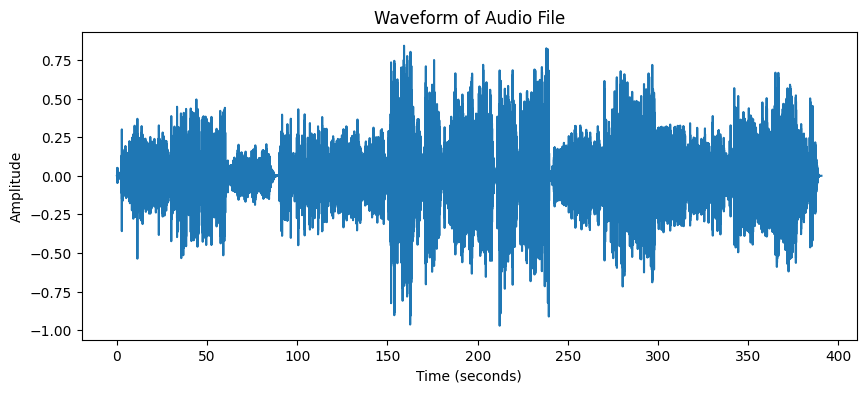

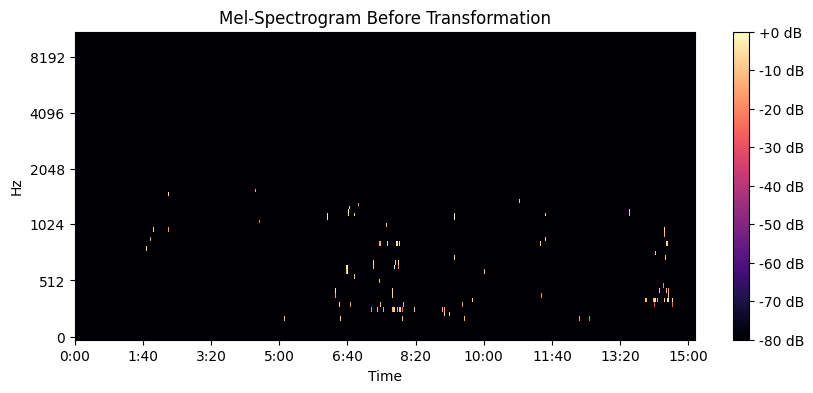

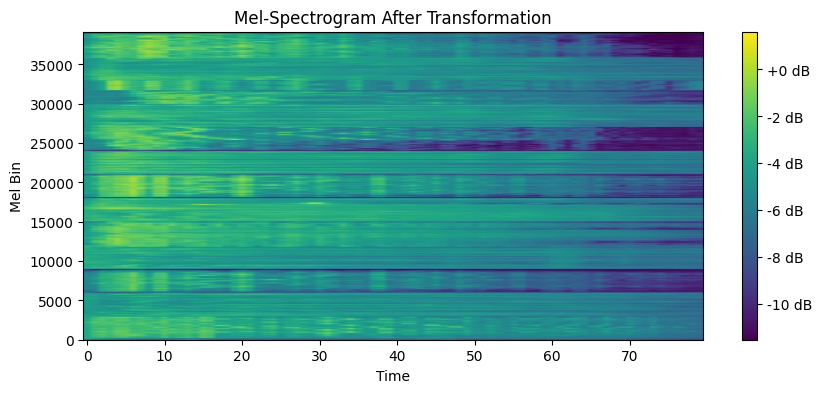

In [10]:
import matplotlib.pyplot as plt
import librosa.display

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, len(y) / sr, len(y)), y)
plt.title('Waveform of Audio File')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.show()

# Plot the mel-spectrogram before rotation and flipping
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(mel_data_nonrot, ref=np.max), sr=sr, hop_length=512, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram Before Transformation')
plt.show()

# Plot the mel-spectrogram after rotation and flipping
plt.figure(figsize=(10, 4))
plt.imshow(mel_data, aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram After Transformation')
plt.xlabel('Time')
plt.ylabel('Mel Bin')
plt.show()

### **Load Audio**

# Shift audio by 150 ms
shifted_audio = audio._spawn(audio.raw_data,
                             overrides={
                                 'frame_rate': audio.frame_rate,
                                 'frame_width': audio.sample_width
                             })
shifted_audio = shifted_audio._spawn(
    shifted_audio.raw_data,
    overrides={'frame_rate': shifted_audio.frame_rate + int(22050 * 0.15)})
shifted_audio = shifted_audio.set_frame_rate(audio.frame_rate)
shifted_audio = shifted_audio.set_channels(audio.channels)

# Export shifted audio as WAV file
shifted_audio.export('shifted_audio.wav', format='wav')

#Load Audio
wavfile = 'shifted_audio.wav'
mel_data = WaveGlow_functions.get_mel(wavfile, stft)
og_mel_data = mel_data
mel_data = np.fliplr(np.rot90(mel_data.data.numpy(), axes=(1, 0)))
og_mel_data_flipped= mel_data
#mel_data = mel_data.data.numpy()


print(mel_data.shape)
# Print out the duration of the original and shifted audio
print("Original audio duration:", audio.duration_seconds)
print("Shifted audio duration:", shifted_audio.duration_seconds)

In [11]:
#Load Subjects
bids_dir = 'data'
subjects = mne_bids.get_entity_vals(bids_dir, 'subject')
#Choose subjects
subject = '13'
acquisition = 'clinical'
task = 'film'
datatype = 'ieeg'
session = 'iemu'

In [12]:
#load subject's channels
channels_path = mne_bids.BIDSPath(subject=subject,
                                  session=session,
                                  suffix='channels',
                                  extension='tsv',
                                  datatype=datatype,
                                  task=task,
                                  acquisition=acquisition,
                                  root=bids_dir)

/tmp/ipykernel_23/1587233290.py:2: FutureWarning: extension should start with a period ".", but got: "tsv". Prepending "." to form: ".tsv". This will raise an exception starting with MNE-BIDS 0.12.
  channels_path = mne_bids.BIDSPath(subject=subject,


In [13]:
channels = pd.read_csv(str(channels_path.match()[0]),
                       sep='\t',
                       header=0,
                       index_col=None)
#print(channels)

In [14]:
#set channel types
data_path = mne_bids.BIDSPath(subject=subject,
                              session=session,
                              suffix='ieeg',
                              extension='vhdr',
                              datatype=datatype,
                              task=task,
                              acquisition=acquisition,
                              root=bids_dir)
raw = mne.io.read_raw_brainvision(str(data_path.match()[0]),
                                  scale=1.0,
                                  preload=False,
                                  verbose=True)
raw.set_channel_types({
    ch_name:
    str(x).lower() if str(x).lower() in ['ecog', 'seeg', 'eeg'] else 'misc'
    for ch_name, x in zip(raw.ch_names, channels['type'].values)
})
raw.drop_channels([
    raw.ch_names[i] for i, j in enumerate(raw.get_channel_types())
    if j == 'misc'
])

/tmp/ipykernel_23/3662225017.py:2: FutureWarning: extension should start with a period ".", but got: "vhdr". Prepending "." to form: ".vhdr". This will raise an exception starting with MNE-BIDS 0.12.
  data_path = mne_bids.BIDSPath(subject=subject,


Extracting parameters from data/sub-13/ses-iemu/ieeg/sub-13_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...


/tmp/ipykernel_23/3662225017.py:14: RuntimeWarning: The unit for channel(s) ECG1, ECG2, MKR1+, MKR2+, abdo+, thor+ has changed from V to NA.
  raw.set_channel_types({


<RawBrainVision | sub-13_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 96 x 201686 (393.9 s), ~99 kB, data not loaded>

print(raw)

### Discard Bad Channels

In [15]:
#bad channels
bad_channels = channels['name'][(channels['type'].isin(['ECOG', 'SEEG']))
                                & (channels['status'] == 'bad')].tolist()
raw.info['bads'].extend([ch for ch in bad_channels])
raw.drop_channels(raw.info['bads'])

<RawBrainVision | sub-13_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 94 x 201686 (393.9 s), ~97 kB, data not loaded>

### Load Raw Data

In [16]:
raw.load_data()

Reading 0 ... 201685  =      0.000 ...   393.916 secs...


<RawBrainVision | sub-13_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 94 x 201686 (393.9 s), ~144.7 MB, data loaded>

In [17]:
n_eeg_channels = int(raw.info['nchan'])  # for subject 01
print('n_eeg_channels', n_eeg_channels)
# raise

n_eeg_channels 94


### Apply notch filter to remove line noise

In [18]:
raw.notch_filter(freqs=np.arange(50, 251, 50))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3381 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  94 out of  94 | elapsed:    1.3s finished


<RawBrainVision | sub-13_ses-iemu_task-film_acq-clinical_run-1_ieeg.eeg, 94 x 201686 (393.9 s), ~144.7 MB, data loaded>

raw.plot()
plt.show()

### Apply common average reference to remove common noise and trends

In [19]:

#CAR
raw_car, _ = mne.set_eeg_reference(raw.copy(), 'average')

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.


gamma = raw_car.copy()
gammacska = gamma.get_data()
print(gammacska.shape)

gamma = raw_car.copy().filter(60,
                              120).apply_hilbert(envelope=True).get_data()  #.T
print('raw_car.shape:', raw_car._data.shape, 'gamma shape: ', gamma.shape)

#Extract signal in gamma range, use Hilbert transform, but can also play around with wavelet decomposition options


gamma = raw_car.copy().filter(60, 120).apply_hilbert(envelope=True).get_data().T

### Read annotation with event markers

In [20]:
custom_mapping = {
    'Stimulus/music': 2,
    'Stimulus/speech': 1,
    'Stimulus/end task': 5
}  # 'Stimulus/task end' in laan
events, event_id = mne.events_from_annotations(raw_car,
                                               event_id=custom_mapping,
                                               use_rounding=False)

Used Annotations descriptions: ['Stimulus/end task', 'Stimulus/music', 'Stimulus/speech']


Using matplotlib as 2D backend.


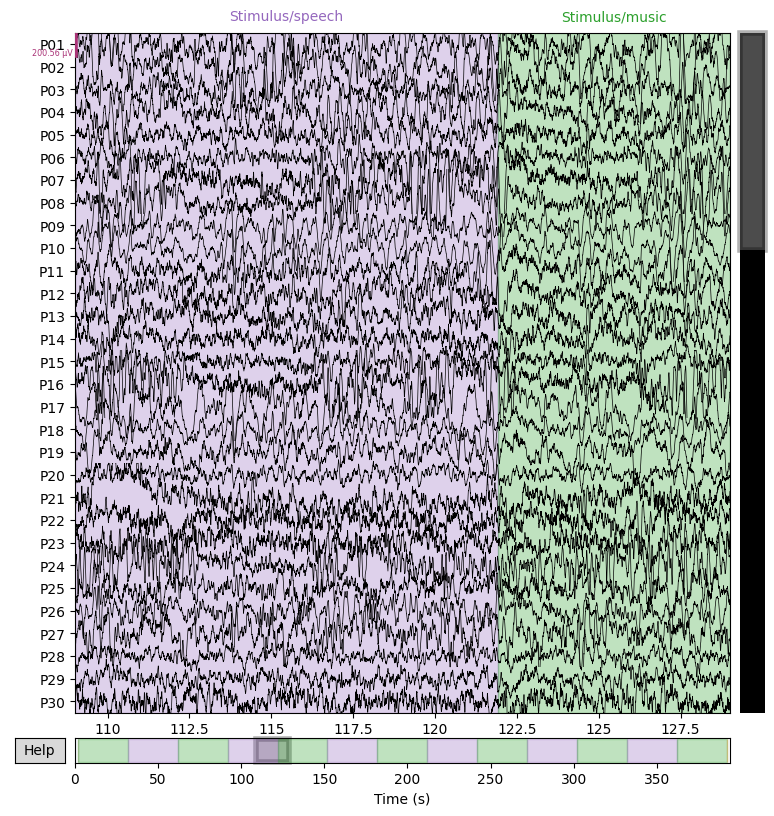

In [21]:
#plotting
raw_car.plot(n_channels=30, scalings='auto', duration=20, start=109)
plt.show()

# assume gamma is a 2D array
np.savetxt("gamma.tsv", gamma, delimiter="\t")

raise

In [22]:
#get EEG SR
n_melspec = 80
samplingFrequency_EEG = raw_car.info['sfreq']

In [23]:
eeg=raw_car.get_data()


#create a copy taht we crop
raw_car_cut = raw_car.get_data()
print(raw_car_cut.shape)
#(n_channels, n_times)

(94, 201686)


In [24]:
print('before cut: ', raw_car._data.shape, mel_data.shape)

raw_car_cut = np.empty((n_eeg_channels, 0))
mel_data_cut = np.empty((0, n_melspec))

# for i in range(6):
for i in range(6):
    start_time = events[2 * i + 1, 0] / raw_car.info['sfreq']
    end_time = events[2 * i + 2, 0] / raw_car.info['sfreq']
    start_idx, end_idx = raw_car.time_as_index([start_time, end_time])
    print(i, 'iEEG index', start_idx, end_idx, end_idx - start_idx)
    n_frames_per_sec = int(1 / frameshift_EEG)
    print(i, 'melspec index', (2 * i + 1) * 30 * n_frames_per_sec,
          (2 * i + 2) * 30 * n_frames_per_sec,
          (2 * i + 2) * 30 * n_frames_per_sec -
          (2 * i + 1) * 30 * n_frames_per_sec)
    # raw_car_cut1 = raw_car._data[:, start_idx:end_idx]
    raw_car_cut1 = eeg[:, start_idx:end_idx]
    raw_car_cut = np.append(raw_car_cut, raw_car_cut1, axis=1)
    mel_data_cut1 = mel_data[(2 * i + 1) * 30 * n_frames_per_sec:(2 * i + 2) *
                             30 * n_frames_per_sec]
    mel_data_cut = np.append(mel_data_cut, mel_data_cut1, axis=0)
# raise
mel_data = mel_data_cut

print('after cut: ', raw_car_cut.shape, mel_data.shape)
# raise
#praat

before cut:  (94, 201686) (39161, 80)
0 iEEG index 16337 31698 15361
0 melspec index 3000 6000 3000
1 iEEG index 47062 62425 15363
1 melspec index 9000 12000 3000
2 iEEG index 77788 93145 15357
2 melspec index 15000 18000 3000
3 iEEG index 108506 123868 15362
3 melspec index 21000 24000 3000
4 iEEG index 139230 154594 15364
4 melspec index 27000 30000 3000
5 iEEG index 169952 185312 15360
5 melspec index 33000 36000 3000
after cut:  (94, 92167) (18000, 80)


In [25]:
#get EEG SR
samplingFrequency_EEG = raw_car.info['sfreq']

# Calculate the length of the signal
length = raw_car_cut.shape[1] / samplingFrequency_EEG

print("The length of the EEG signal is", length, "s")
print(samplingFrequency_EEG)

The length of the EEG signal is 180.013671875 s
512.0


### Prepare Data for training

### Extract features

In [26]:
#Extract HG features
print('calculating Hilbert...', raw_car_cut.shape)
# eeg_fft = np.empty((n_max_frames, n_freq_bands, n_eeg_channels * (2 * modelOrder_EEG + 1) ))
# feat_Hilbert_1 = extractHG(raw_car_cut,samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=1, bandpass_max=200)
feat_Hilbert_1 = extractHG(np.rot90(raw_car_cut),
                           samplingFrequency_EEG,
                           windowLength=winL_EEG,
                           frameshift=frameshift_EEG,
                           bandpass_min=1,
                           bandpass_max=70)
# feat_Hilbert_2 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=51, bandpass_max=100)
# feat_Hilbert_3 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=101, bandpass_max=150)
# feat_Hilbert_4 = extractHG(np.rot90(current_raw_eeg_data),samplingFrequency_EEG, windowLength=winL_EEG,frameshift=frameshift_EEG, bandpass_min=151, bandpass_max=200)

calculating Hilbert... (94, 92167)


In [27]:
#Stack features
feat_Hilbert_1 = stackFeatures(feat_Hilbert_1,
                               modelOrder=modelOrder_EEG,
                               stepSize=stepSize_EEG)

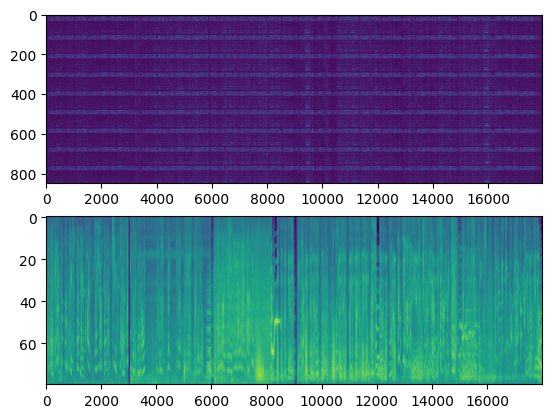

mel & iEEG:  (18000, 80) (17956, 846)


In [28]:
plt.subplot(211)
plt.imshow(np.rot90(feat_Hilbert_1), aspect='auto')

plt.subplot(212)
plt.imshow(np.rot90(mel_data), aspect='auto')
plt.show()

eeg = feat_Hilbert_1
print('mel & iEEG: ', mel_data.shape, feat_Hilbert_1.shape)

In [29]:
min_len = np.min((len(eeg), len(mel_data)))
eeg = eeg[0:min_len]
mel_data = mel_data[0:min_len]

In [30]:
print('mel & iEEG: ', mel_data.shape, eeg.shape)

mel & iEEG:  (17956, 80) (17956, 846)


In [31]:
train_index = np.arange(0, int(0.8 * eeg.shape[0]))
test_index = np.arange(int(0.8 * eeg.shape[0]), eeg.shape[0])

In [32]:
# train-validation-test split
eeg_train = eeg[0:int(len(eeg) * 0.8)]
eeg_valid = eeg[int(len(eeg) * 0.8):int(len(eeg) * 0.9)]
eeg_test = eeg[int(len(eeg) * 0.9):]

In [33]:
melspec_train = mel_data[0:int(len(mel_data) * 0.8)]
melspec_valid = mel_data[int(len(mel_data) * 0.8):int(len(mel_data) * 0.9)]
melspec_test = mel_data[int(len(mel_data) * 0.9):]

In [34]:
# scale input to [0-1]
eeg_scaler = MinMaxScaler()
# eeg_scaler = StandardScaler(with_mean=True, with_std=True)
eeg_train_scaled = eeg_scaler.fit_transform(eeg_train)
eeg_valid_scaled = eeg_scaler.transform(eeg_valid)
eeg_test_scaled = eeg_scaler.transform(eeg_test)

In [35]:
# scale outpit mel-spectrogram data to zero mean, unit variances
melspec_scaler = StandardScaler(with_mean=True, with_std=True)
melspec_train_scaled = melspec_scaler.fit_transform(melspec_train)
melspec_valid_scaled = melspec_scaler.transform(melspec_valid)
melspec_test_scaled = melspec_scaler.transform(melspec_test)

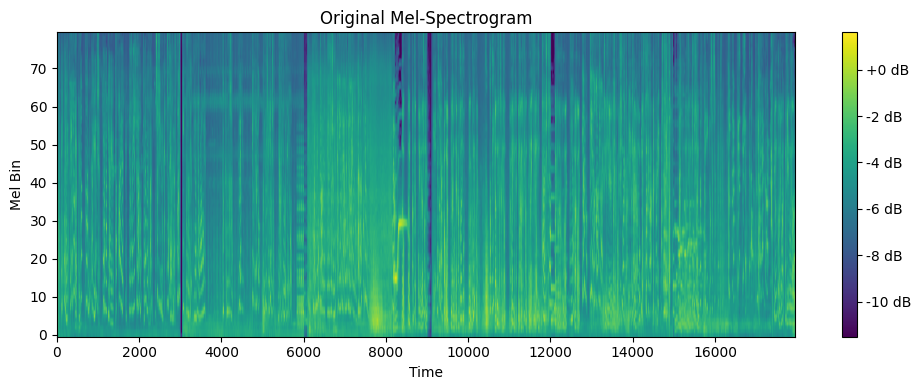

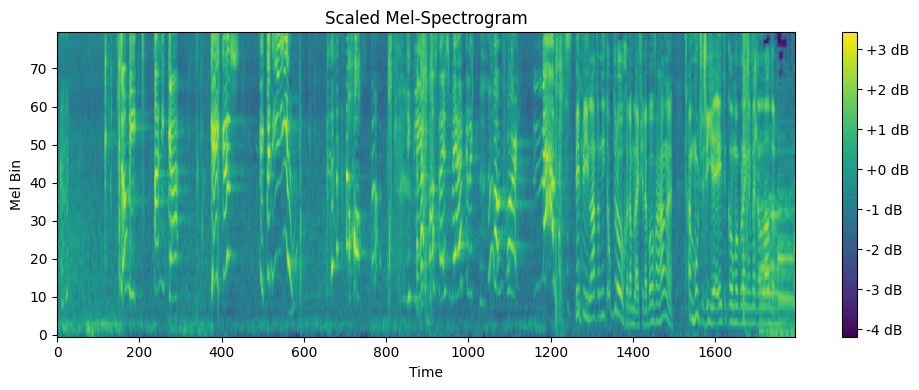

In [36]:
import matplotlib.pyplot as plt

# Assuming mel_data is your original mel-spectrogram and melspec_test_scaled is the scaled version
# Also assuming both are NumPy arrays

# Plot original mel-spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(mel_data.T, aspect='auto', origin='lower')
plt.title('Original Mel-Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Bin')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

# Plot scaled mel-spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(melspec_test_scaled.T, aspect='auto', origin='lower')
plt.title('Scaled Mel-Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Bin')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


### FC-DNN

In [37]:
# 5 hidden layers, with 1000 neuron on each layer
model = Sequential()
model.add(
    Dense(1000,
          input_dim=eeg_train_scaled.shape[1],
          kernel_initializer='normal',
          activation='relu'))
model.add(
    Dense(1000,
          input_dim=eeg_train_scaled.shape[1],
          kernel_initializer='normal',
          activation='relu'))
model.add(
    Dense(1000,
          input_dim=eeg_train_scaled.shape[1],
          kernel_initializer='normal',
          activation='relu'))
model.add(Dense(80, kernel_initializer='normal', activation='linear'))

2023-12-06 08:31:56.087463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 08:31:56.088972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 08:31:56.089242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 08:31:56.100275: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 08:31:56.100823: I tensorflow/compile

In [38]:
# compile model
model.compile(loss='mean_squared_error',
              metrics=['mean_squared_error'],
              optimizer='adam')
earlystopper = EarlyStopping(monitor='val_mean_squared_error',
                             min_delta=0.0001,
                             patience=5,
                             verbose=1,
                             mode='auto')

if not (os.path.isdir('models_iEEG_to_melspec/')):
    os.mkdir('models_iEEG_to_melspec/')

In [39]:
# early stopping to avoid over-training
# csv logger
current_date = '{date:%Y-%m-%d_%H-%M-%S}'.format(date=datetime.now())
print(current_date)
# n_eeg_channels * (2 * modelOrder_EEG + 1)
model_name = 'models_iEEG_to_melspec/iEEG-Hilbert_to_melspec_DNN_modelOrder-' + str(
    modelOrder_EEG).zfill(
        2) + '_freqBands-1_' + '_sub' + subject + '_' + current_date
logger = CSVLogger(model_name + '.csv', append=True, separator=';')
checkp = ModelCheckpoint(model_name + '_weights_best.h5',
                         monitor='val_loss',
                         verbose=1,
                         save_best_only=True,
                         mode='min')

2023-12-06_08-31-57


serialize scalers to pickle
pickle.dump(eeg_scaler, open(model_name + '_eeg_scaler.sav', 'wb'))
pickle.dump(melspec_scaler, open(model_name + '_melspec_scaler.sav', 'wb'))

### Run training

In [40]:
history = model.fit(
    eeg_train_scaled,
    melspec_train_scaled,
    epochs=100,
    batch_size=32,
    shuffle=True,
    verbose=1,
    callbacks=[earlystopper, logger, checkp],
    validation_split=0.9,
    validation_data=(eeg_valid_scaled, melspec_valid_scaled),
)

Epoch 1/100


2023-12-06 08:32:01.229091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-06 08:32:01.558869: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fe76d568ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-06 08:32:01.558935: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2023-12-06 08:32:01.647623: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-06 08:32:02.577468: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


448/449 [============================>.] - ETA: 0s - loss: 0.9176 - mean_squared_error: 0.9176
Epoch 1: val_loss improved from inf to 0.79161, saving model to models_iEEG_to_melspec/iEEG-Hilbert_to_melspec_DNN_modelOrder-04_freqBands-1__sub13_2023-12-06_08-31-57_weights_best.h5
449/449 [==============================] - 9s 8ms/step - loss: 0.9172 - mean_squared_error: 0.9172 - val_loss: 0.7916 - val_mean_squared_error: 0.7916
Epoch 2/100
446/449 [============================>.] - ETA: 0s - loss: 0.7741 - mean_squared_error: 0.7741
Epoch 2: val_loss did not improve from 0.79161
449/449 [==============================] - 3s 7ms/step - loss: 0.7737 - mean_squared_error: 0.7737 - val_loss: 0.9478 - val_mean_squared_error: 0.9478
Epoch 3/100
448/449 [============================>.] - ETA: 0s - loss: 0.6539 - mean_squared_error: 0.6539
Epoch 3: val_loss did not improve from 0.79161
449/449 [==============================] - 3s 7ms/step - loss: 0.6539 - mean_squared_error: 0.6539 - val_loss: 

In [41]:
# save model
model_json = model.to_json()
with open(model_name + '_model.json', "w") as json_file:
    json_file.write(model_json)

# here the training of the DNN is finished
# load back best weights
model.load_weights(model_name + '_weights_best.h5')
# remove model file
# os.remove(model_name + '_weights_best.h5')

### Visualize predicted melspectogram

32/32 [==============================] - 0s 2ms/step
Best validation MSE: 0.7916
Minimum training loss: 0.3886


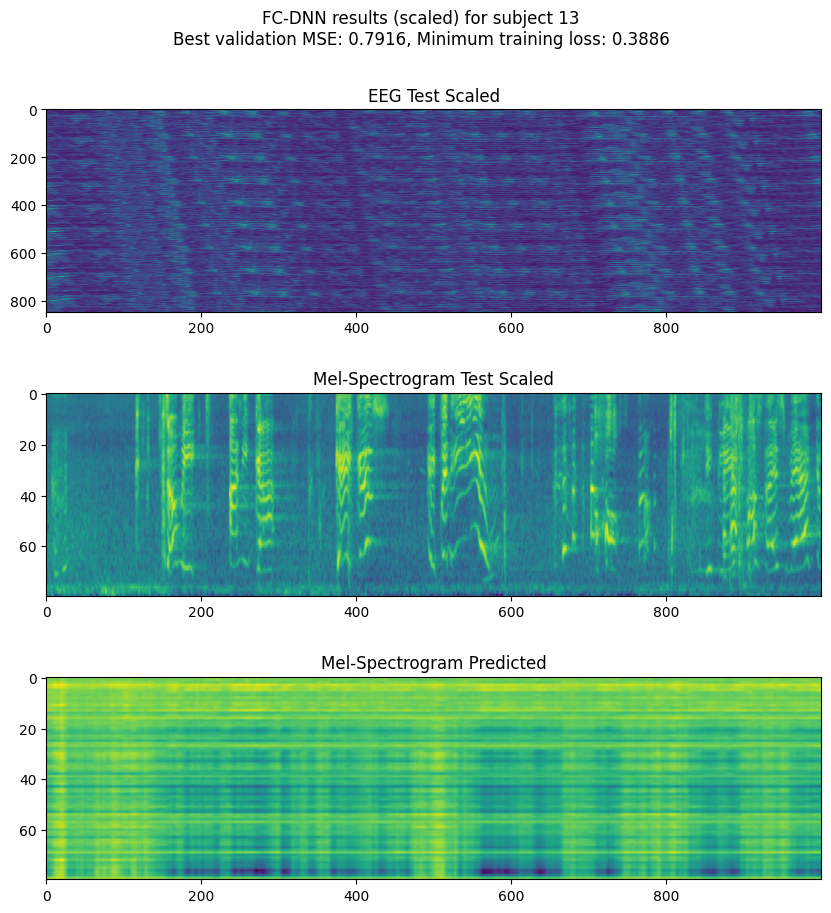

In [42]:
# melspec_predicted = model.predict(eeg_test_scaled[0:500])
melspec_predicted = model.predict(eeg_test_scaled[0:1000])
# melspec_predicted = melspec_predicted[0:500]
# test_melspec = test_melspec[]

#best stuff

best_val_mse = min(history.history['val_mean_squared_error'])
print(f'Best validation MSE: {best_val_mse:.4f}')

min_train_loss = min(history.history['loss'])
print(f'Minimum training loss: {min_train_loss:.4f}')

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].imshow(np.rot90(eeg_test_scaled[0:1000]), aspect='auto')
axs[0].set_title('EEG Test Scaled')
axs[1].imshow(np.rot90(melspec_test_scaled[0:1000]), aspect='auto')
axs[1].set_title('Mel-Spectrogram Test Scaled')
axs[2].imshow(np.rot90(melspec_predicted[0:1000]), aspect='auto')
axs[2].set_title('Mel-Spectrogram Predicted')
plt.suptitle(
    f'FC-DNN results (scaled) for subject {subject}\nBest validation MSE: {best_val_mse:.4f}, Minimum training loss: {min_train_loss:.4f}'
)
plt.subplots_adjust(hspace=0.4)

plt.savefig(model_name + '_EEG_scaled_plots.png')
plt.show()

### Audio synth

In [43]:
# Provide the actual mel spectrogram (melspec_predicted) and sampling frequency (samplingFrequency) from your FC-DNN output
samplingFrequency = 16000

# Convert mel spectrogram to audio using Griffin-Lim algorithm
audio = librosa.feature.inverse.mel_to_audio(melspec_predicted,
                                             sr=samplingFrequency)

# Save the audio to a WAV file
output_file = subject + ' predicted_audio_fc-DNN.wav'
sf.write(output_file, audio, samplingFrequency)

/usr/local/lib/python3.8/dist-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


KeyboardInterrupt: 